# Advanced Machine Learning - programming assignment 1

*Due: Friday November 29th*

* Max Verweij - 6791409
* Teymur Rzali - 4625471

### Further instructions:
* Code quality is considered during the assessment. Make sure your code is properly commented. 
* Submit your code in Blackboard using **one** of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name (i.e. submitter_collaborator.ipynb). 
* **Failure to follow these instructions can affect the assignment grade.**

## Multi-armed Bandits

In this programming assignment, we will look at how we can solve a k-armed bandit problem as discussed in the lecture. Expect for winning at the slot machines, you are expect to better understand the tradeoff between exploration and exploiation. 

Here are the objectives of this assignment:
1.   Get familier with the Open-AI gym/gymnasium environment,
2.   Implement your own k-armed bandit environment based on the gym framework,
3.   Use an epsilon-greedy algorithm to find the optimal action for this k-armed bandit problem,
4.   Play with the parameter epsilon and identify a reasonable setting for balancing exploration and exploiation. 
    

### 0. Please check the given 'README' file

### 1. Let's start with the OpenAI gym

Gym/Gymnasium (https://gymnasium.farama.org/) is a wide-used toolkit for developing and comparing reinforcement learning algorithms. 

1. Gym/Gymnasium makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano. 

2. The library is a collection of test problems — **environments** — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

**Great!** Now let's import the gymnasium class and work on a basic example of gym code.


In [1]:
import gymnasium

Like mentioned above, gymnasium's main purpose is to provide a large collection of **environments** that expose a common interface. You can find a listing of those environments below (they are Markov decision process(MDP) environments and we discussed MDP in our lecture 2), as follows:

In [2]:
from gymnasium import envs
print(envs.registry)

{'CartPole-v0': EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'CartPole-v1': EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'MountainCar-v0': EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_ch

We are now going to explain how the RL framework of gym works. 
- An **ENVIRONMENT**, 
- You also have an **AGENT**,
- The agent takes an **ACTION**, in our case, 10 actions are possible to take,
- When a single **ACTION** is chosen and fed to our **ENVIRONMENT**, the **ENVIRONMENT** measures how good the action was taken and produces a **REWARD**, which is usually a numeric value.

In MDP problems, the **ENVIRONMENT** will also provides an **OBSERVATION**, which represets the state of the **ENVIRONMENT** at the current moment. In the multi-armed bandit problems, there is no **OBSERVATION** (or state) or one constant state. 

Please read the 'Basic usage' https://gymnasium.farama.org/introduction/basic_usage/ for better understanding the framework. 


### 2. Implement your own environment

Next, we are going to implement our own environment following the framework of gym. This enviroment is a gambiling room with ten different slot machines (a 10-armed bandit problem). Similar with examples given in the lecture, the reward of each slot machine follows a normal distribution, but the average reward (mean) and variance of each action are different. Your goal is to determine the optimal action from all possible actions/machines. 

The core gym interface is **Env**, which is the unified environment interface. There is no interface for agents. The following are the Env methods you should know:

- `step(self, action)`: Steps the environment by one timestep. Returns observation, reward, done, info.
- `reset(self)`: Resets the environment to an initial state. Returns an initial observation. Each call of `reset()` should yield an environment suitable for a new episode, independent of previous episodes. Because there is no state transition in multi-armed bandit problems, this function is not used here.
- `render(self, mode='human')`: Renders one frame of the environment. The default mode will do something human friendly, such as pop up a window. In this assignment, there is no need to create a pop up window. 

Before writing your own codes, read through the readme of github page of gymasium (https://github.com/Farama-Foundation/Gymnasium). You are also recommended to read at least the codes for one simple environment and one example agent.

#### 2.1 Self-defined Slot Machine

**Please fill in the missing codes in the function sample (1 point).**

In [3]:
import numpy as np

class slotMachine:
    """
        A slot machine contains a reward distribution that randomly generated with restricted mean and standard deviation. 
            sample function: generates a reward at each time step based on the given reward distribition
    """
    def __init__(self):
        self.mu = np.random.uniform(-5, 5)  # mean
        self.sigma = np.random.uniform(0.5, 1)  # standard deviation

    def sample(self):
        # Generating a reward based on the given reward distribution
        return np.random.normal(self.mu, self.sigma)

#### 2.2 Game Environment
**Please fill in the missing codes in function step (1 point) in the environment.** 

In [4]:
from gymnasium import spaces

# The environment has to inherit the interface of gymnasium.Env
class GamblingRoom(gymnasium.Env):
    """
    A k-armed bandit environment: a gambling room with slot machines, allows the agents to interact with it.
        r_machines: A list of slot machines, each gamblingRoom contains k number of slotMachines
    """
    def __init__(self, k, seed=None):
        # set u seed
        self.seed(seed)     
        # initialize reward distribution for each action/machine
        self.r_machines = []
        for i in range(k):
            # each gamblingRoom contains k number of slotMachines
            self.r_machines.append(slotMachine())

        self.num_arms = k
        self.action_space = spaces.Discrete(self.num_arms)
        self.observation_space = spaces.Discrete(1)
        # for our bandit environment, the state is constant
        self.state = 0
    
    # step up the environment based on the selected action,
    # return the constant state, reward, done = false, and info 
    # for now, we do not have to worry about the DONE and INFO variables.
    def step(self, action):
        assert self.action_space.contains(action)
        done = False

        # Sample reward from the selected slot machine
        reward = self.r_machines[action].sample()
        
        return self.state, reward, done, {}

    # random seed used for reproducibility purposes
    def seed(self, seed):
        if seed is not None:
            np.random.seed(seed)
    
    def reset(self):
        pass

    def render(self, mode='human', close=False):
        pass

    def close(self):
        pass

### 3. Implement an agent with the epsilon greedy algorithm

In this part, you are expected to implement an RL agent. To decide the action to take at each time step, this agent uses the epsilon greedy algorithm introduced in the lecture.

**Please fill in the missing codes in function select_action (1.5 points) and update_parameters (1 point) in the agent.** Feel free to import the needed packages if there are any.

In [5]:
class EplisonGreedyAgent:
    def __init__(self, k, e):
        # set up the number of arms/actions
        self.num_arms = k
        # set up the value of epsilon
        self.epsilon = e
        # init the estimated values of all actions
        self.Qvalues = np.zeros(k)
        # init the numbers of time step that every action is selected
        self.stepSize = np.zeros(k)

    ##
    # select the action to take at the current time step
    # (for MDP, choose the action based on state; for k-armed bandit, no state given)
    # return: the action to take
    ##
    def select_action(self):
        if np.random.rand() < self.epsilon:  # Exploration: choose a random action
            action = np.random.choice(self.num_arms)
        else:  # Exploitation: randomly choose among actions with the highest Q-value
            max_value = np.max(self.Qvalues)
            max_indices = np.where(self.Qvalues == max_value)[0]  # Get all indices with the max Q-value
            action = np.random.choice(max_indices)  # Randomly select one of the max indices
        return action


    ##
    # Update the Q-values of the agent based on received rewards
    # input: action_index = the action, reward = the reward from this action
    # return: null
    ##
    def update_parameters(self, action, reward):
        # Increment stepSize for the chosen action
        self.stepSize[action] += 1
        
        # Update the Q-value of the chosen action using the incremental formula
        self.Qvalues[action] += (reward - self.Qvalues[action]) / self.stepSize[action]
        

### 4. Run the simulation, play with parameters and analyse results

Finally, we write codes for running the simulation. 

In order to decrease the effect of randomness, we usually conduct multiple simulation runs and average the results. In the implementation, you may start with one run, then use the variable `num_runs` for running multiple simulations.

In each run, you shall setup the `epsilon` and number of time step `num_episodes` (0.01 and 500 by default). Then, after the initlization of our agent and environment, **please fill in the missing codes (with ??? or TODO: to be filled). (2.5 points)**

In [6]:
num_action = 10
num_seed = 5
num_runs = 100  # number of simulation runs
num_episodes = 500  # number of steps in each run
epsilon = 0.01

# init the environment and set up the random seed
env = GamblingRoom(num_action, seed=num_seed)

# delete the wrap
env = env.unwrapped

# show the action space
print(env.action_space) 

total_rewards = 0

# run multiple simulations
for i_run in range(num_runs):
    # Initialize the epsilon-greedy RL agent 
    agent = EplisonGreedyAgent(num_action, epsilon)
    
    # Track the total rewards for each run
    total_rewards = 0

    # In each simulation run, loop through the episodes
    for episode in range(num_episodes):
        # Select an action
        action = agent.select_action()
        
        # Take the action in the environment
        _, reward, done, _ = env.step(action)
        
        # Update the agent's parameters based on the reward received
        agent.update_parameters(action, reward)
        
        # Accumulate the total reward for the current run
        total_rewards += reward

    # Print the total reward after each run for monitoring purposes

env.close()

Discrete(10)


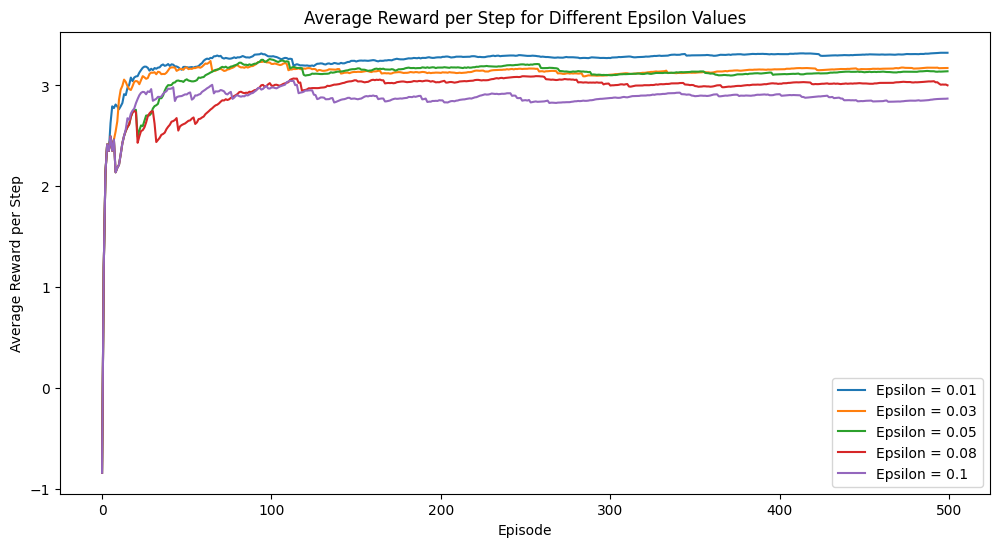

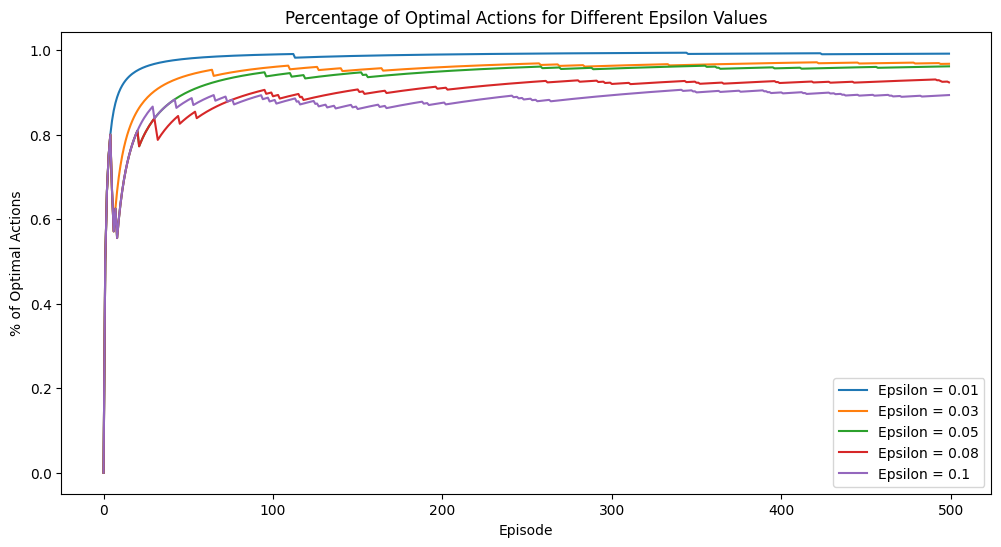

In [7]:
import numpy as np
import matplotlib.pyplot as plt

num_actions = 10  # Number of slot machines
num_runs = 100  # Number of simulation runs
num_episodes = 500  # Number of steps in each run
epsilon_values = [0.01, 0.03, 0.05, 0.08, 0.1,]  # Different epsilon values to test
environment = 42

# Initialize storage for results
results = {}

# Run experiments for each epsilon value
for epsilon in epsilon_values:
    avg_rewards = []
    optimal_action_percents = []

    for run in range(num_runs):
        # Initialize environment and agent
        env = GamblingRoom(num_actions, seed=environment)
        agent = EplisonGreedyAgent(num_actions, epsilon)
        env = env.unwrapped

        total_rewards = 0
        optimal_action_count = 0
        rewards_per_episode = []
        optimal_actions_per_episode = []

        # Run episodes
        for episode in range(num_episodes):
            # Agent selects an action
            action = agent.select_action()
            
            # Environment provides reward
            _, reward, _, _ = env.step(action)
            agent.update_parameters(action, reward)

            # Track rewards and optimal actions
            total_rewards += reward
            optimal_action = np.argmax([machine.mu for machine in env.r_machines])
            if action == optimal_action:
                optimal_action_count += 1

            # Store metrics
            rewards_per_episode.append(total_rewards / (episode + 1))
            optimal_actions_per_episode.append(optimal_action_count / (episode + 1))

        avg_rewards.append(rewards_per_episode)
        optimal_action_percents.append(optimal_actions_per_episode)

    # Store results: average across all runs
    results[epsilon] = {
        "avg_reward": np.mean(avg_rewards, axis=0),
        "optimal_action_percent": np.mean(optimal_action_percents, axis=0),
    }


# Plot the results
# Plot 1: Average reward per step
plt.figure(figsize=(12, 6))
for epsilon, metrics in results.items():
    plt.plot(metrics["avg_reward"], label=f"Epsilon = {epsilon}")
plt.xlabel("Episode")
plt.ylabel("Average Reward per Step")
plt.title("Average Reward per Step for Different Epsilon Values")
plt.legend()
plt.show()

# Plot 2: Percentage of optimal actions
plt.figure(figsize=(12, 6))
for epsilon, metrics in results.items():
    plt.plot(metrics["optimal_action_percent"], label=f"Epsilon = {epsilon}")
plt.xlabel("Episode")
plt.ylabel("% of Optimal Actions")
plt.title("Percentage of Optimal Actions for Different Epsilon Values")
plt.legend()
plt.show()


Now it's time to examine the performance of algorithms with different epsilon values (different exploration strategies) in multiple simulation runs. 

You shall play with the parameter epsilon under 2 or 3 different gambling environments (by initlizing different reward distributions for machines). **For each environment, try at least 2 different values of epsilon and identify a reasonable epsilon value that could balance the exploration and exploiation**. **Instead of handing in your codes for this part, please select one environment you have tested and describe your environment and experimental settings (1 point)**. Then, provide an explanation on how you identify the good epsilon value in this environment and why it is a good one **(1 point)**. 

Few instructions:
- Your answer shall include two plots presenting compariable measures of the different epsilon settings (e.g. the average reward per step and % of optimal action). **(1 point)** 
- You shall present the average results from at least 100 simulation runs. Remember that the gambling environment CANNOT be changed over those runs used for calculating the average results. 
- You may adjust the total time steps when the learning needs more time for a cerain epsilon value, but do not over spend your time on this.    

### Results interpretation

For this experiment, we tested an environment with 10 slot machines, initialized with a fixed random seed of 42. Each configuration was evaluated over 100 simulation runs, with 500 steps per run. We experimented with 5 different epsilon values ranging from 0 to 0.01 to analyze and validate their effects on agent performance.

**Average Reward per Step:** In the initial phase, where exploration dominates, the agent randomly selects actions, including suboptimal ones, to gather information about the environment. During the transition phase, we observe a steady increase in the average reward as the agent begins exploiting the knowledge it has accumulated. In the final phase, the curve stabilizes with minor fluctuations, indicating the agent has identified the optimal actions and is primarily exploiting them.

**Percentage of Optimal Actions:** Similarly, in the initial phase, the percentage of optimal actions is low as the agent is exploring various options. During the transition phase, this percentage increases as the agent shifts its focus from exploration to exploitation. By the end, the percentage stabilizes near 100%, signifying the agent consistently selects the optimal actions in most scenarios.

Among the tested epsilon values, an epsilon of 0.01 demonstrated the best balance between exploration and exploitation. Conversely, higher epsilon values led to excessive exploration, delaying convergence to optimal actions. Epsilon = 0.01 provided enough exploration to learn effectively while allowing the agent to exploit its knowledge for higher rewards. Overall, we can consider epsilon less than 0.05 sufficient as in the later phrase of the graphs they stabilize and percentage is near to the 100%.

You are almost done! Before handing in, make sure that the codes you hand in work, and that all plots are shown. **Submit just one file per team.** Please make sure that you submit a .zip file with images.

Again, make sure you name this file according to your last names.